Students:
- 0001138787 - Lorenzo Venturi - lorenzo.venturi14@studio.unibo.it
- 0001172880 - Chayan Talukder - chayan.talukder@studio.unibo.it

# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [ ]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 31.48 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

# Part 1

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 22.5 MB/s eta 0:00:00


In [ ]:
# imports
import pandas as pd
import numpy as np
import random
from pathlib import Path
import os
from typing import Optional
import json
import matplotlib.pyplot as plt
import copy
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import DataLoader, ConcatDataset
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchmetrics.classification.accuracy import Accuracy
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

In [ ]:
# Seed settings
def fix_random(seed: int) -> None:
    """
        Fix all the possible sources of randomness.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
# Runtime settings
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


## Data preparation

In [ ]:
# splitting the data
train_data = OxfordPetDataset(split="train")
val_data = OxfordPetDataset(split="val")
test_data = OxfordPetDataset(split="test")

### Data exploration

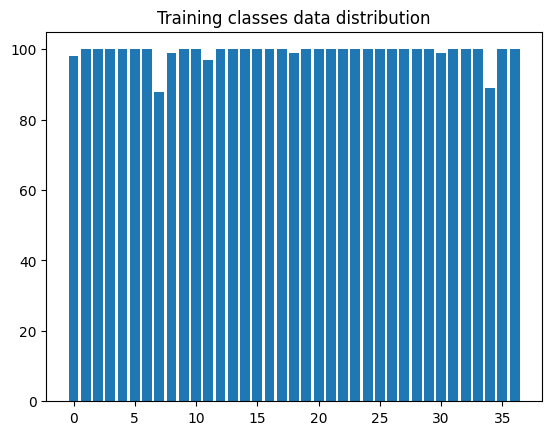

In [ ]:
train_data = OxfordPetDataset(split="train")
train_classes, counter_training_class = np.unique(train_data.labels, return_counts=True)
plt.title("Training classes data distribution")
plt.bar(train_classes, counter_training_class)
plt.show()

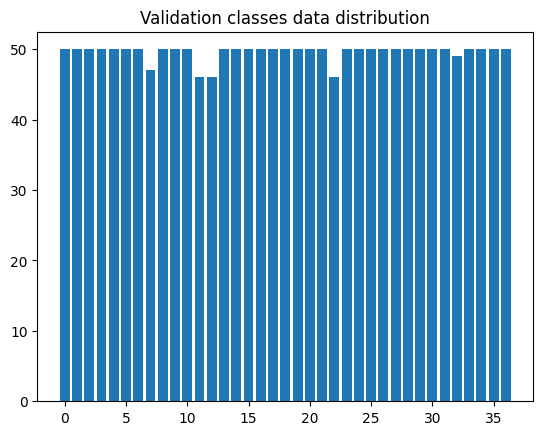

In [ ]:
val_data = OxfordPetDataset(split="val")
validation_classes, counter_validation_class = np.unique(val_data.labels, return_counts=True)
plt.title("Validation classes data distribution")
plt.bar(validation_classes, counter_validation_class)
plt.show()

The data looks well balanced above all the classes.

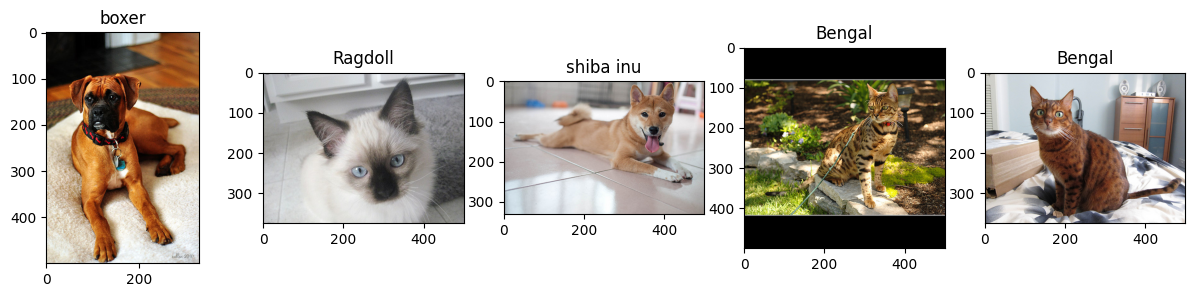

In [ ]:
# sample training data visualization
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

# Get a list of all image names
all_names = train_data.names

# random indexes
indexes = random.sample(range(len(all_names)), num_samples)

for i, idx in enumerate(indexes):
    img,label = train_data[idx]
    # Get the class name using the label
    class_name = all_names[idx].split('_')[:-1]
    class_name = ' '.join(class_name)

    axes[i].imshow(img)
    axes[i].set_title(class_name)

plt.show()

In [ ]:
# Classes distribution
print(f"Number of classes in the train dataset: {train_data.get_num_classes()}")
print(f"Number of classes in the validation dataset: {val_data.get_num_classes()}")
print(f"Number of classes in the test dataset: {test_data.get_num_classes()}")

Number of classes in the train dataset: 37
Number of classes in the validation dataset: 37
Number of classes in the test dataset: 37


## Hyperparameters and parameter setting

In [ ]:
cfg = {

    # Pre-processing's parameters
    "resize_size": 256,
    "crop_size": 224,

    # Training's parameters
    "batch_size": 32,
    "num_epochs": 30,

    # Optimizer's parameters
    "lr": 1e-3,
    "wd": 3e-4, # weight decay
    "step_size": 5
}

num_classes = train_data.get_num_classes()

### Data pre-processing

In [ ]:
def calculate_mean_std(dataset,batch_size=64):
    '''
    Function to calculate the mean and std of the dataset
    '''
    loader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)  # number of samples in batch
        data = data.view(batch_samples, 3, -1)  # [B, C, H*W]

        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean, std

temp_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

temp_train_dataset = OxfordPetDataset(split="train", transform=temp_transform)
mean, std = calculate_mean_std(temp_train_dataset)

Here we show the implemented data transformation.We apply different image preprocessing pipelines ( with agumentations for training ) and applies them when loading the Oxford Pet Dataset.

In [ ]:
data_transforms = {
    "train": T.Compose([
        T.RandomResizedCrop(cfg["crop_size"], scale=(0.8,1.0)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),
    "val": T.Compose([
        T.Resize(cfg["resize_size"]),
        T.CenterCrop(cfg["crop_size"]),
        T.ToTensor(),
        T.Normalize(mean, std)
    ]),
    "test": T.Compose([
        T.Resize(cfg["resize_size"]),
        T.CenterCrop(cfg["crop_size"]),
        T.ToTensor(),
        T.Normalize(mean, std)
    ])
}
train_dataset = OxfordPetDataset(split="train",transform=data_transforms["train"])
test_dataset = OxfordPetDataset(split="test",transform=data_transforms["test"])
val_dataset = OxfordPetDataset(split="val",transform=data_transforms["val"])

## Network and training

In [ ]:
# utils functions
def getModelParameters(model):
  """
  Function to calculate the total number of parameters of the network
  args:
  - model
  return:
  - number of parameters
  """
  tot=0
  for parameter in model.parameters():
    tot+=parameter.numel()
  return tot

def printModelParameters(model):
    """
    Function to print the parameters of the network including the percentage of the total for each layer.
    """
    # total number of trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total Trainable Parameters: {total_params:,}")
    print("-" * 95)
    print(f"{'Layer Name':<60} | {'Parameters':<15} | {'Percentage (%)':<15}")
    print("-" * 95)

    # Iterate over named parameters to print details
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            percentage = (param_count / total_params) * 100
            print(f"{name:<60} | {param_count:<15,} | {percentage:>14.3f} %")

    print("-" * 95)

def plotTrainingHistory(histories, plot_title):
  """
  Function to plot the training and validation loss and accuracy for multiple training runs
  Args:
    histories : list of dictionaries, each dictionary contains the logs for a single training run
    plot_title
  """
  colors=["#1f77b4","#ff7f0e","#2ca02c"]

  fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
  fig.suptitle(plot_title,fontsize=16)

  for i, logs in enumerate(histories):

    run_label =f"Run {i+1} (Seed {logs.get('seed', 'N/A')})"
    color =colors[i%len(colors)]
    epochs =range(1,len(logs["val_loss"])+1)

    # loss
    ax1.plot(epochs,logs["train_loss"],label=f"{run_label} Train",color=color, alpha=0.8)
    ax1.plot(epochs,logs["val_loss"],linestyle='--', label=f"{run_label} Val",color=color,alpha=0.8)

    # accuracy
    ax2.plot(epochs, logs["train_acc"],label=f"{run_label} Train",color=color,alpha=0.8)
    ax2.plot(epochs, logs["val_acc"], linestyle='--',label=f"{run_label} Val",color=color,alpha=0.8)

  ax1.set_title("Loss over Epochs")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.grid(True,linestyle=':',alpha=0.6)
  ax1.legend()

  ax2.set_title("Accuracy over Epochs")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.grid(True,linestyle=':',alpha=0.6)
  ax2.legend()

  plt.tight_layout(rect=[0,0.03,1,0.95])
  plt.show()


### Trainer class
Handles the training pipeline for one run.

It includes:
- Initializing the model, data loaders, optimizer, and scheduler
- Training the model for a specified number of epochs
- Evaluating the model on validation and test sets
- Storing training history for plotting
- Saving the best performing model based on the validation accuracy

In [ ]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            test_loader: DataLoader,
            device: torch.device,
            num_classes: int,
            optimizer: torch.optim.Optimizer,
            scheduler: torch.optim.lr_scheduler,
            num_epochs: int,
            seed: int,
            print_training: bool = True
        ) -> None:

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = num_epochs
        self.model = model.to(device)
        self.optimizer = optimizer
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = scheduler
        self.print_training=print_training

        self.step = 0
        self.best_val_acc = 0.0

        # History for multiple seeds plotting
        self.history = {
            "seed": seed,
            "batch_train_losses":[],
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":[],
            "test_acc":[]
        }

        self.ckpt_path=Path("ckpts")
        self.ckpt_path.mkdir(exist_ok=True)
        self.best_model_path=self.ckpt_path /f"{seed}.pt"

    def train(self) -> None:
        """
        Function to train the model for a specified number of epochs
        This method iterates through each epoch, performs a training pass,
        evaluates on the validation set, and then performs a final evaluation on the test set.
        """
        for epoch in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train()
            batch_losses = []
            acc_train = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels, label_smoothing=0.1)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if self.scheduler is not None:
                  self.scheduler.step()

                batch_losses.append(loss.item())
                acc_train(F.softmax(pred, dim=-1), labels)
                self.step += 1

            # End of epoch — store train metrics
            epoch_train_loss = np.mean(batch_losses)
            epoch_train_acc = acc_train.compute().item()
            self.history["batch_train_losses"].append(batch_losses)
            self.history["train_loss"].append(epoch_train_loss)
            self.history["train_acc"].append(epoch_train_acc)

            # Validation after each epoch
            val_loss, val_acc = self.eval("val", store=True)
            if ((epoch+1)%5==0 or epoch==0) and self.print_training==True:
              print(f"[Epoch {epoch+1}/{self.num_epochs}] Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Final test evaluation
        self.eval("test", store=True)

    @torch.no_grad()
    def eval(self, split: str, store: bool = False):
        """
        Performs an evaluation pass on a specified dataset split.

        Args:
            split :The dataset split to evaluate on val/test.
            store :If True, stores the evaluation metrics in the history dictionary.

        Returns:
            tuple: A tuple containing the average loss and accuracy for the evaluation split.
        """
        self.model.eval()
        loader = self.val_loader if split == "val" else self.test_loader

        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)
        total_loss = 0.0

        for imgs, labels in loader:
            imgs =imgs.to(self.device)
            labels =labels.to(self.device)

            pred = self.model(imgs)
            batch_loss = F.cross_entropy(pred,labels)
            total_loss += batch_loss.item() * imgs.size(0)
            acc(F.softmax(pred,dim=-1),labels)

        loss = total_loss / len(loader.dataset)
        accuracy = acc.compute().item()

        if store:
            self.history[f"{split}_loss"].append(loss)
            self.history[f"{split}_acc"].append(accuracy)

        if split == "val" and accuracy > self.best_val_acc:
            self.best_val_acc = accuracy
            torch.save(self.model.state_dict(), self.best_model_path)

        return loss, accuracy

# Ablation study
We start with the best performing network found, then we are going to remove components and make changes in order to show how our implementation decisions led to better results.

## Best network architecture overview
The architecture here presented is a modular convolutional neural network insipred partially by **ResNetv2**, designed for image classification.

### The Stem block
- **Conv2D (7×7, stride 2)** → Large receptive field to quickly capture low-level features.  
- **BatchNorm + ReLU** → Improves training stability and introduces non-linearity.  
- **MaxPool (3×3, stride 2)** → Further reduces spatial dimensions early on.

### The custom residual blocks
Each block follows: BN->Relu->Conv ( pre-activation, as in ResNet-v2)
1. **First 3×3 convolution**: May downsample (stride > 1).  
2. **Second 3×3 convolution**: Keeps same resolution.  
3. **Shortcut connection**:
  - Identity if shape matches.  
  - 1×1 convolution (with BN) if downsampling or channel change is needed.

Pre-activation helps improving the gradient flow and eases optimization by placing normalization and activation before the convolution, it allows the gradients to pass through the identity more directly and reduces the vanishing gradients in deep networks.

### The block sequence
- Two `64→64` residual blocks.  
- Two `64→128`
- Two `128→256`
- Two `256→512`
- Final **BN + ReLU** for a better feature scaling before the classification.

### Classifier
- **Adaptive Average Pooling (1×1)** → Outputs a fixed-size vector regardless of input size (reduces drastically the spatial dimensions)
- **Flatten** → Prepares features for dense layer.  
- **Linear layer** → Maps to `num_classes`.



In [ ]:
class CustomBlock(nn.Module):
  """
  Custom residual block with pre-activations
  """
  def __init__(self,
               input_channels: int,
               output_channels: int,
               stride: int = 1,
               use_batchNorm:bool=True,
               use_skipConnections=True):

    super().__init__()
    self.use_batchNorm=use_batchNorm
    self.use_skipConnections=use_skipConnections

    # BN-->ReLU-->Conv
    self.block=nn.Sequential(
        nn.BatchNorm2d(input_channels) if self.use_batchNorm else nn.Identity() ,
        nn.ReLU(inplace=True) ,
        nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=stride,padding=1,bias=False))

    # BN-->ReLU-->Conv
    self.block2=nn.Sequential(
        nn.BatchNorm2d(output_channels) if self.use_batchNorm else nn.Identity(),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channels,output_channels,kernel_size=3,stride=1,padding=1,bias=False))

    self.shortcut=nn.Sequential()
    if self.use_skipConnections and (stride!=1 or input_channels!=output_channels):
      self.shortcut=nn.Sequential(
          nn.Conv2d(input_channels,output_channels,kernel_size=1,stride=stride,bias=False),
          nn.BatchNorm2d(output_channels) if self.use_batchNorm else nn.Identity())

  def forward(self,x: Tensor) -> Tensor:
    out=self.block(x)
    out=self.block2(out)
    if self.use_skipConnections:
      out+=self.shortcut(x)
    return out

In [ ]:
class CustomModelModular(nn.Module):
  """
  Modular class that divide the model into a stem, conv. block annd a classifier head.
  """
  def __init__(self, stem_block,conv_blocks,classifier):
    super().__init__()
    self.stem_block = nn.Sequential(*stem_block)
    self.conv_blocks = nn.Sequential(*conv_blocks)
    self.classifier_head = nn.Sequential(*classifier)

  def forward(self, x):
      x = self.stem_block(x)
      x = self.conv_blocks(x)
      # adaptive pooling create a fixed size output vector, making the model more flexible
      x = F.adaptive_avg_pool2d(x, (1, 1))
      x = torch.flatten(x, 1)
      x = self.classifier_head(x)
      return x

In [ ]:
class PetCustomModel(CustomModelModular):
  def __init__(self,
               num_classes:int,
               use_batchNorm:bool=True,
               use_stem:bool=True,
               use_skipConnections:bool=True,
               stem_channels:int=64,
               block_channels: List[int]=[64,128,256,512],
               num_blocks: List[int]=[2,2,2,2],
               strides: List[int]=[1,2,2,2],
               fc_features: Optional[List[int]] = None,
               feature_dimension: Optional[int] = None
               ):
    """
    Args:
    - num_classes = the number of output classes
    - use_stem = if or not use the stem layer
    - use_batchNorm = if or not use batch normalization
    - use_skipConnections = if or not use skip connections
    - stem_channels = number of the output channels for the stem
    - block_channels = numbers of block for each stage
    - strides = list of strides for the first block of each stage
    - fc_features= list of the hidden features sizes of the classifier
    - feature_dimension = number of features after flattening the conv block output
    """
    assert len(block_channels) == len(num_blocks)
    assert len(block_channels) == len(strides)

    # stem layer
    if use_stem:
      stem_block = [
          nn.Conv2d(3, stem_channels, kernel_size=7, stride=2, padding=3, bias=False),
          nn.BatchNorm2d(stem_channels) if use_batchNorm else nn.Identity(),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      ]
      current_channels = stem_channels
    else:
      stem_block=[nn.Identity()]
      current_channels=3

    # conv blocks
    conv_blocks = []
    for i, (out_channels, stride) in enumerate(zip(block_channels,strides)):
        conv_blocks.append(CustomBlock(current_channels,out_channels,stride=stride, use_batchNorm=use_batchNorm, use_skipConnections=use_skipConnections))
        current_channels = out_channels
        for _ in range(num_blocks[i] - 1):
            conv_blocks.append(CustomBlock(current_channels,current_channels,stride=1, use_batchNorm=use_batchNorm, use_skipConnections=use_skipConnections))

    conv_blocks.append(nn.BatchNorm2d(current_channels) if use_batchNorm else nn.Identity())
    conv_blocks.append(nn.ReLU(inplace=True))

    # classifier head
    final_classifier_head=[]
    in_features=block_channels[-1]
    #the pooling and flattening happen outside the block
    if fc_features:
        for num_hid_features in fc_features:
            final_classifier_head.append(nn.Linear(in_features, num_hid_features))
            final_classifier_head.append(nn.ReLU(inplace=True))
            in_features = num_hid_features
        final_classifier_head.append(nn.Linear(in_features, num_classes))
    else:
        final_classifier_head.append(nn.Linear(in_features, num_classes))


    super().__init__(
            stem_block=stem_block,
            conv_blocks=conv_blocks,
            classifier=final_classifier_head
        )

In [ ]:
model=PetCustomModel(num_classes=num_classes,use_batchNorm=True).to(device)
printModelParameters(model)

Total Trainable Parameters: 11,195,621
-----------------------------------------------------------------------------------------------
Layer Name                                                   | Parameters      | Percentage (%) 
-----------------------------------------------------------------------------------------------
stem_block.0.weight                                          | 9,408           |          0.084 %
stem_block.1.weight                                          | 64              |          0.001 %
stem_block.1.bias                                            | 64              |          0.001 %
conv_blocks.0.block.0.weight                                 | 64              |          0.001 %
conv_blocks.0.block.0.bias                                   | 64              |          0.001 %
conv_blocks.0.block.2.weight                                 | 36,864          |          0.329 %
conv_blocks.0.block2.0.weight                                | 64              |    

### Multiple seed training procedure
- Prepare the data loaders ( train, validation, test )
- Initialize the model for each seed to ensure independent runs
- Instantiate the optimizer ( we used **AdamW** with a pre-fixed weight decay parameters)
- Instantiate the scheduler using **OneCycleLR** that initially increase the LR and then gradually decrease it
- start the training process ( train the model for each seed )
- loading the best model and evaluate it on test set
- aggregate results across the seeds and compute a final evaluation
- plot the aggregated training history

In this way we ensure fair comparison.


In [ ]:
def train_MultipleSeeds(
    model_fn,
    cfg,
    train_dataset,
    val_dataset,
    test_dataset,
    device,
    print_training=True,
    seeds=(42, 123, 2024),
    title="Training for multiple seeds"
    ):
  all_run_histories = []
  final_test_accuracies = []

  train_loader = DataLoader(train_dataset, batch_size=cfg['batch_size'], shuffle=True, pin_memory=True,num_workers=2, persistent_workers=True)
  val_loader = DataLoader(val_dataset, batch_size=cfg['batch_size'], shuffle=False, pin_memory=True,num_workers=2, persistent_workers=True)
  test_loader = DataLoader(test_dataset, batch_size=cfg['batch_size'], shuffle=False, pin_memory=True,num_workers=2, persistent_workers=True)

  for seed in seeds:
    print(f"\n{'='*25} RUNNING FOR SEED: {seed} {'='*25}\n")
    fix_random(seed)
    model = model_fn().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['wd'])
    scheduler = OneCycleLR(
        optimizer,
        max_lr=cfg['lr'] * 2,
        epochs=cfg['num_epochs'],
        steps_per_epoch=len(train_loader)
    )
    # Trainer
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        num_classes=train_dataset.get_num_classes(),
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=cfg['num_epochs'],
        print_training=print_training,
        seed=seed
    )
    # Train
    trainer.train()
    # Evaluate best checkpoint
    print(f"\nEvaluating best model for seed {seed} on the test set")
    best_model_state = torch.load(trainer.best_model_path)
    trainer.model.load_state_dict(best_model_state)
    test_loss, test_acc = trainer.eval("test", store=False)
    print(f"Final Test Results for Seed {seed}: Loss={test_loss:.4f}, Accuracy={test_acc:.4f}")

    # Store results
    all_run_histories.append(trainer.history)
    final_test_accuracies.append(test_acc)

  # Summary
  print("\n" + "="*60)
  print("SUMMARY")
  print("="*60)
  mean_acc = np.mean(final_test_accuracies)
  std_acc = np.std(final_test_accuracies)
  print(f"Seeds used: {seeds}")
  print(f"Final Test Accuracies: {[f'{acc:.4f}' for acc in final_test_accuracies]}")
  print(f"Mean Test Accuracy: {mean_acc:.4f}")
  print(f"Std Dev of Test Accuracy: {std_acc:.4f}")
  print("="*60)

  # Plot
  plotTrainingHistory(all_run_histories, title)

  return all_run_histories,final_test_accuracies

In [ ]:
results = {}

### Best model

Reached accuracy on test set: **60%**.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Train Loss: 3.4191, Train Acc: 0.0916 | Val Loss: 3.3890, Val Acc: 0.1052
[Epoch 5/30] Train Loss: 2.9470, Train Acc: 0.2134 | Val Loss: 3.1658, Val Acc: 0.1668
[Epoch 10/30] Train Loss: 2.3157, Train Acc: 0.4026 | Val Loss: 2.7769, Val Acc: 0.2465
[Epoch 15/30] Train Loss: 1.7234, Train Acc: 0.6307 | Val Loss: 2.2534, Val Acc: 0.3680
[Epoch 20/30] Train Loss: 1.2402, Train Acc: 0.8226 | Val Loss: 2.0060, Val Acc: 0.4389
[Epoch 25/30] Train Loss: 0.9224, Train Acc: 0.9635 | Val Loss: 1.6726, Val Acc: 0.5453
[Epoch 30/30] Train Loss: 0.8513, Train Acc: 0.9864 | Val Loss: 1.5960, Val Acc: 0.5698

Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.4579, Accuracy=0.6121

========================= RUNNING FOR SEED: 123 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Train Loss: 3.4280, Train Acc: 0.0886 | Val Loss: 3.2959, Val Acc: 0.1025
[Epoch 5/30] Train Loss: 2.9751, Train Acc: 0.1965 | Val Loss: 3.5166, Val Acc: 0.0943
[Epoch 10/30] Train Loss: 2.3207, Train Acc: 0.3947 | Val Loss: 2.8586, Val Acc: 0.2481
[Epoch 15/30] Train Loss: 1.7537, Train Acc: 0.6113 | Val Loss: 2.4572, Val Acc: 0.3010
[Epoch 20/30] Train Loss: 1.2730, Train Acc: 0.8119 | Val Loss: 1.9550, Val Acc: 0.4482
[Epoch 25/30] Train Loss: 0.9334, Train Acc: 0.9548 | Val Loss: 1.6199, Val Acc: 0.5507
[Epoch 30/30] Train Loss: 0.8598, Train Acc: 0.9869 | Val Loss: 1.6179, Val Acc: 0.5534

Evaluating best model for seed 123 on the test set
Final Test Results for Seed 123: Loss=1.4770, Accuracy=0.5910

========================= RUNNING FOR SEED: 2024 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Train Loss: 3.4280, Train Acc: 0.0853 | Val Loss: 3.3199, Val Acc: 0.0938
[Epoch 5/30] Train Loss: 2.9679, Train Acc: 0.2022 | Val Loss: 3.0428, Val Acc: 0.1690
[Epoch 10/30] Train Loss: 2.3303, Train Acc: 0.3979 | Val Loss: 2.7298, Val Acc: 0.2514
[Epoch 15/30] Train Loss: 1.7353, Train Acc: 0.6244 | Val Loss: 2.1399, Val Acc: 0.3888
[Epoch 20/30] Train Loss: 1.2602, Train Acc: 0.8207 | Val Loss: 1.8682, Val Acc: 0.4727
[Epoch 25/30] Train Loss: 0.9287, Train Acc: 0.9635 | Val Loss: 1.5981, Val Acc: 0.5556
[Epoch 30/30] Train Loss: 0.8469, Train Acc: 0.9869 | Val Loss: 1.5736, Val Acc: 0.5682

Evaluating best model for seed 2024 on the test set
Final Test Results for Seed 2024: Loss=1.4067, Accuracy=0.6073

SUMMARY
Seeds used: (42, 123, 2024)
Final Test Accuracies: ['0.6121', '0.5910', '0.6073']
Mean Test Accuracy: 0.6035
Std Dev of Test Accuracy: 0.0090


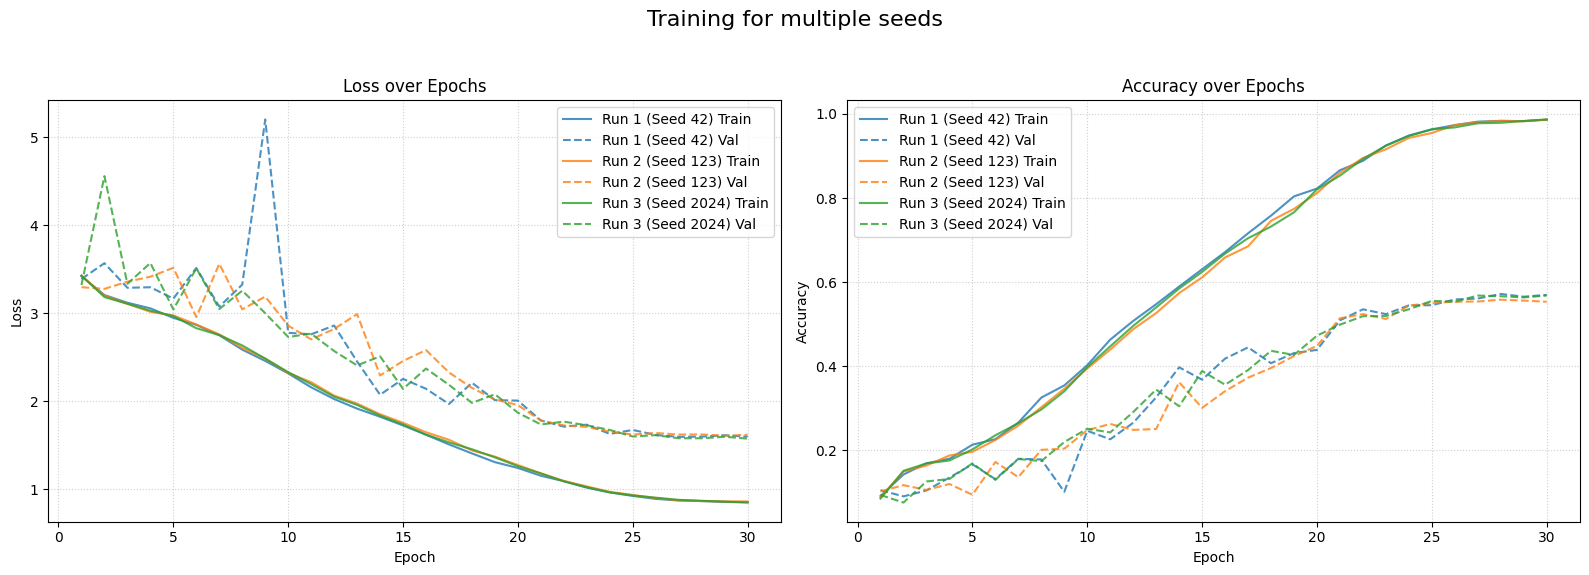

In [ ]:
# We define a model factory function (each time we get a new instance)
model_factory = lambda: PetCustomModel(num_classes=num_classes, use_batchNorm=True)

histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    print_training=True
)
# we save the results for the comparison
results["Best_Model"] = {
    "histories": histories,
    "accuracies": accuracies
}

To test the effectiveness of each component of the proposed architecture, we partially remove and change components of the network and test the resulting performance. What we expect is a decrease of the performances.

We perform the following experiments on the model architecture:
- A smaller stem layer.
- No stem layer at all.
- A smaller convolution block.
- A smaller number of channels.
- A smaller fully-connected layer.
- No batch normalization.
- No skip connections.

In addition, we perform the following experiments on the hyperparameters:
- Smaller weight decay.
- A higher learning rate.
- A smaller batch size.

### No batch-norm

It removes stabilization of activations, causing vanishing/exploding gradients and slower or unstable training. As we can see the network trained like that does not improve.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=3.4598, Accuracy=0.0639

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.0639']
Mean Test Accuracy: 0.0639
Std Dev of Test Accuracy: 0.0000


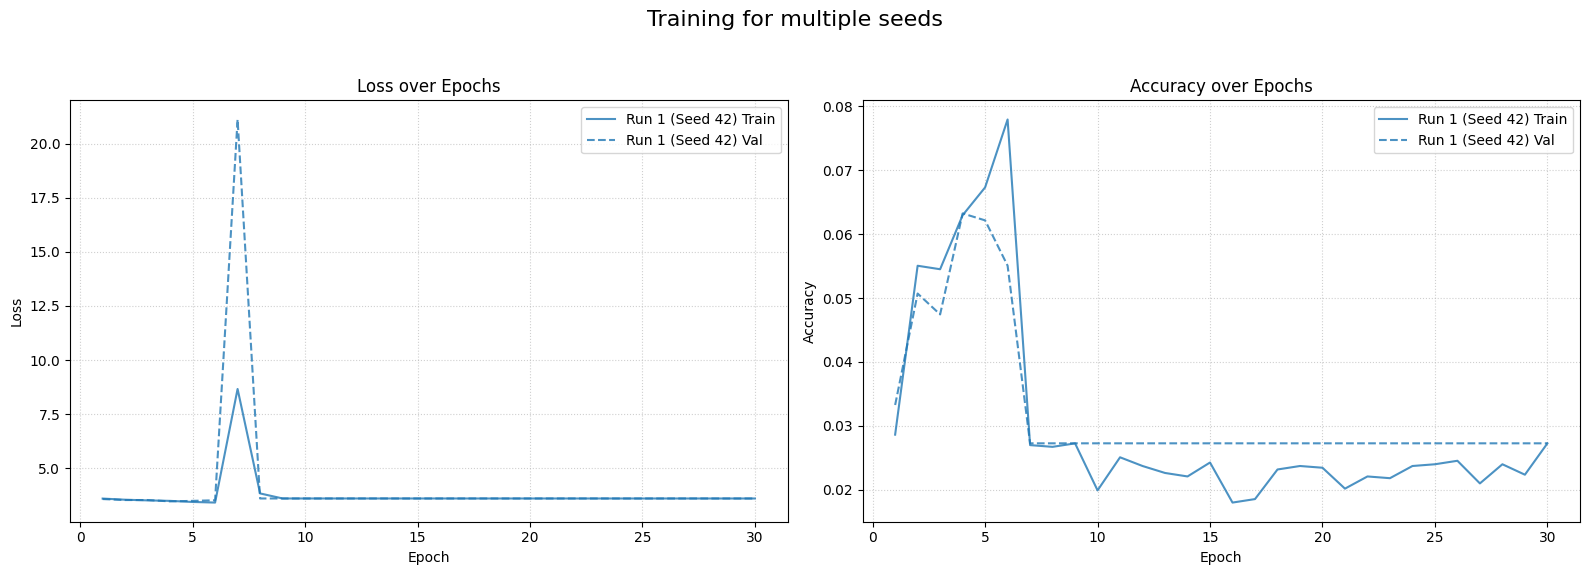

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes, use_batchNorm=False)

histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["no_batch_norm"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Small STEM

It reduces the ability to extract lowe level features, it should lead to a weaker representation from the start.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.4573, Accuracy=0.5964

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.5964']
Mean Test Accuracy: 0.5964
Std Dev of Test Accuracy: 0.0000


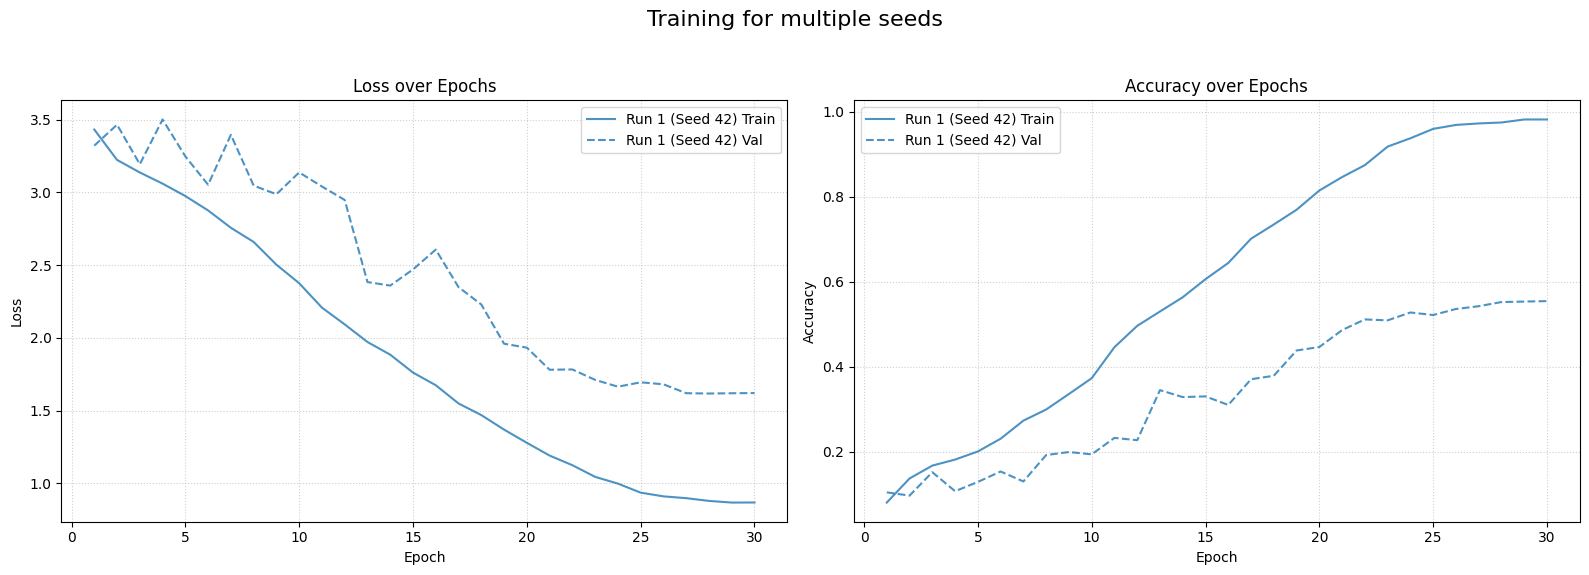

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes, stem_channels=16)
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["Small_Stem"] = {
    "histories": histories,
    "accuracies": accuracies
}

### No STEM

It causes higher computational costs because we do not reduce the spatial dimensions, very slow training (5x slower), and makes it hard for the model to captures edges, textures or shapes.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.7203, Accuracy=0.4951

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.4951']
Mean Test Accuracy: 0.4951
Std Dev of Test Accuracy: 0.0000


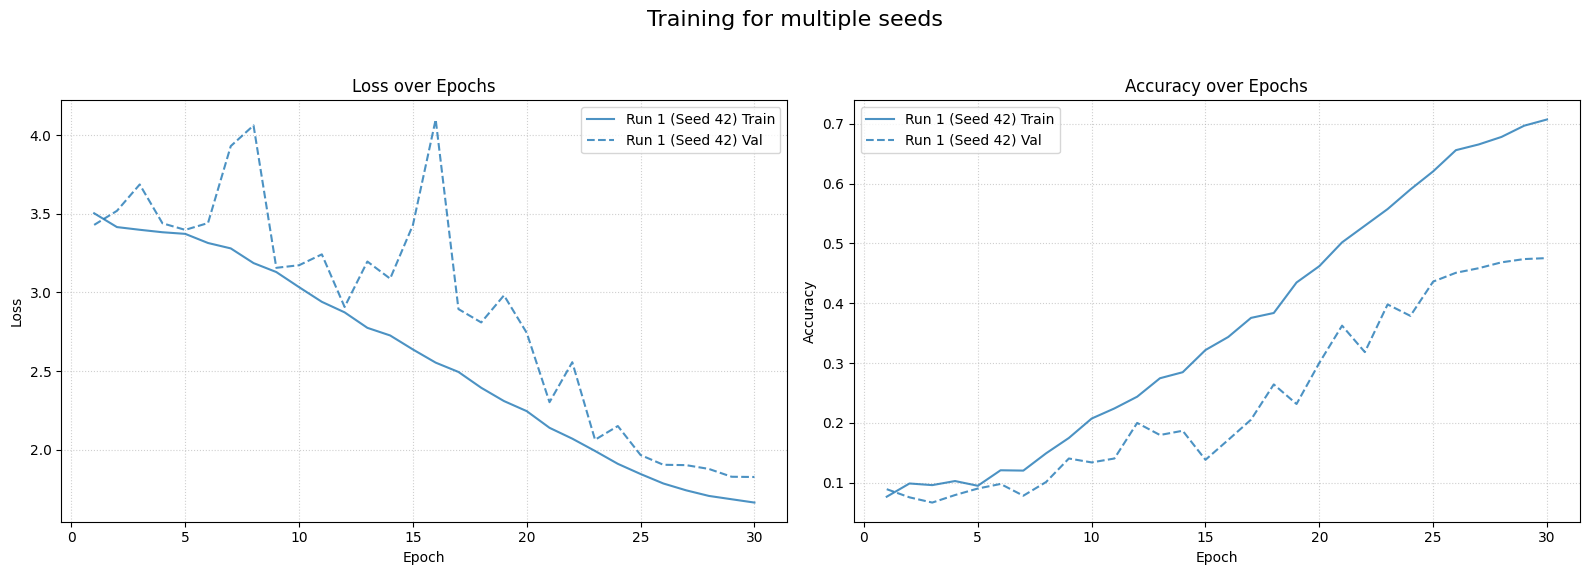

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes, use_stem=False)
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["No_STEM"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Small Conv block

It decreases the receptive field and representational power, limiting the model’s capacity to learn complex features.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.4402, Accuracy=0.5834

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.5834']
Mean Test Accuracy: 0.5834
Std Dev of Test Accuracy: 0.0000


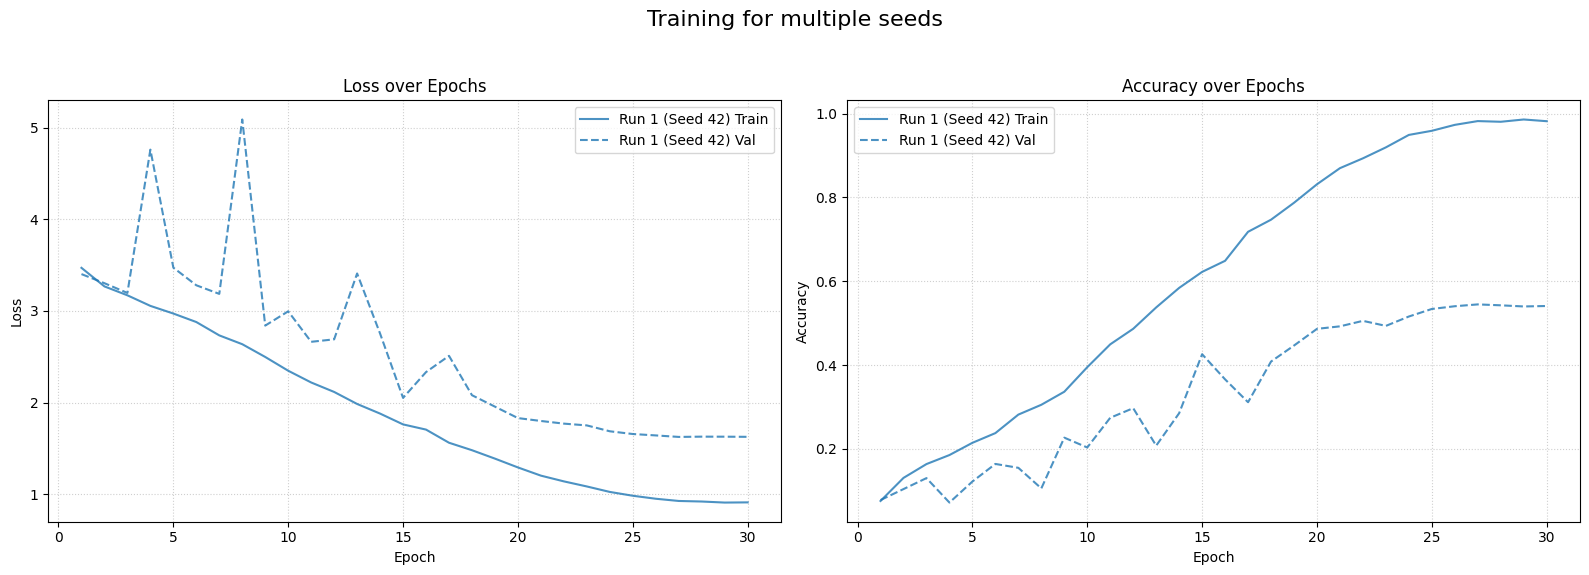

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes, num_blocks=[1,1,1,1])
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["Small_Conv"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Smaller channels
Reduces feature diversity, so the network cannot capture as many patterns.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.4514, Accuracy=0.6002

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.6002']
Mean Test Accuracy: 0.6002
Std Dev of Test Accuracy: 0.0000


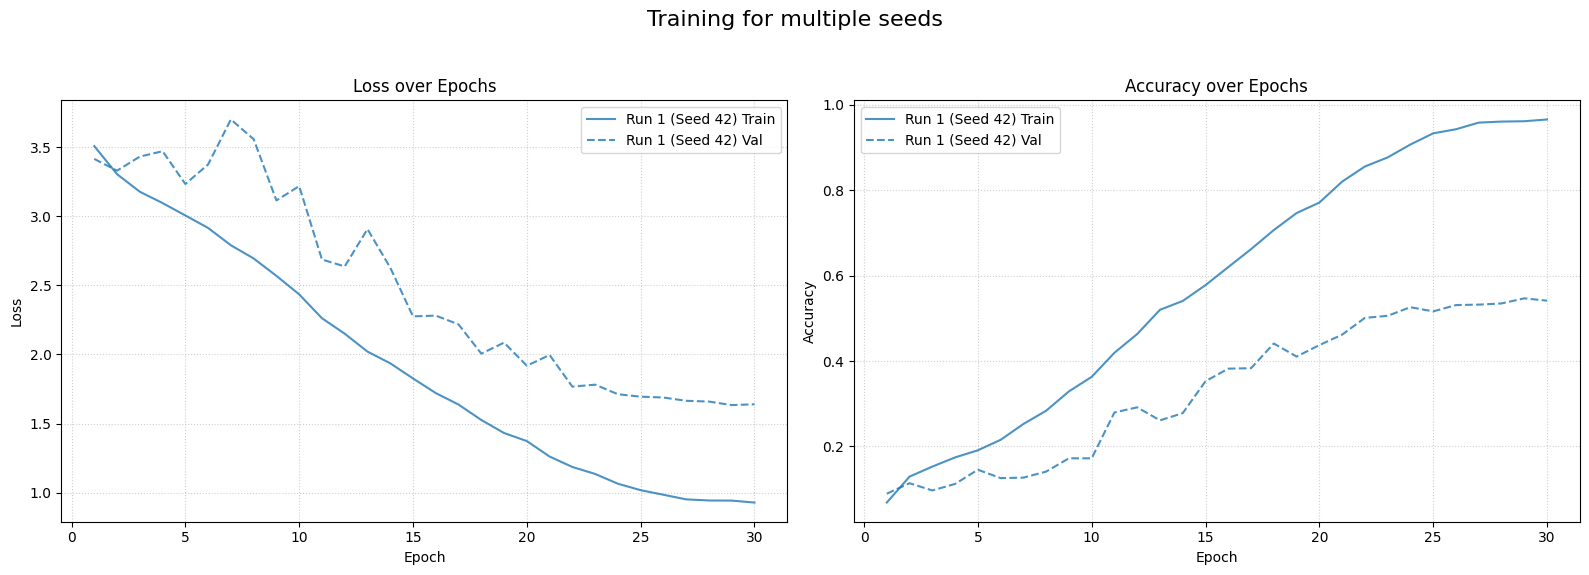

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes, block_channels=[32,64,128,256])
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["Smaller_Channels"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Smaller fully connected
Limits the capacity of the classifier to separate classes effectively.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.5547, Accuracy=0.5580

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.5580']
Mean Test Accuracy: 0.5580
Std Dev of Test Accuracy: 0.0000


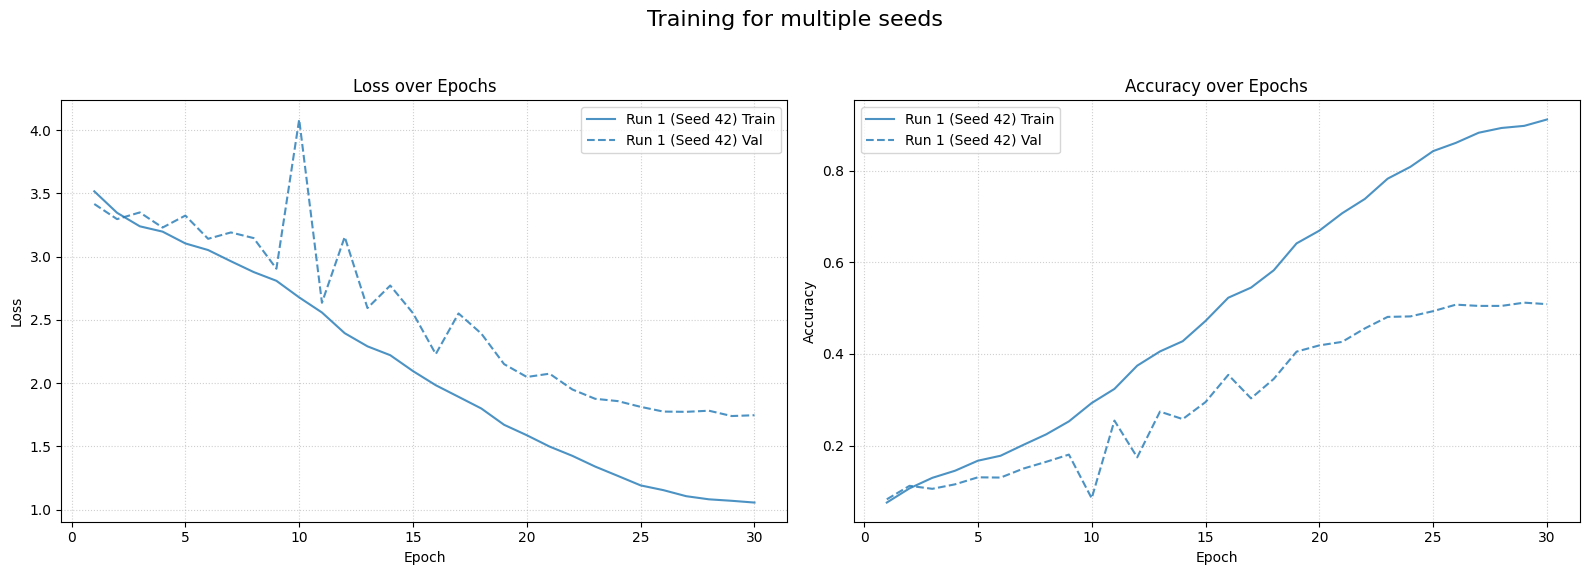

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes, fc_features=[128])
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["Smaller_FC"] = {
    "histories": histories,
    "accuracies": accuracies
}

### No skip connections
Prevents information from bypassing deeper layers, leading to vanishing gradients and degraded learning in deeper networks.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.6686, Accuracy=0.5130

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.5130']
Mean Test Accuracy: 0.5130
Std Dev of Test Accuracy: 0.0000


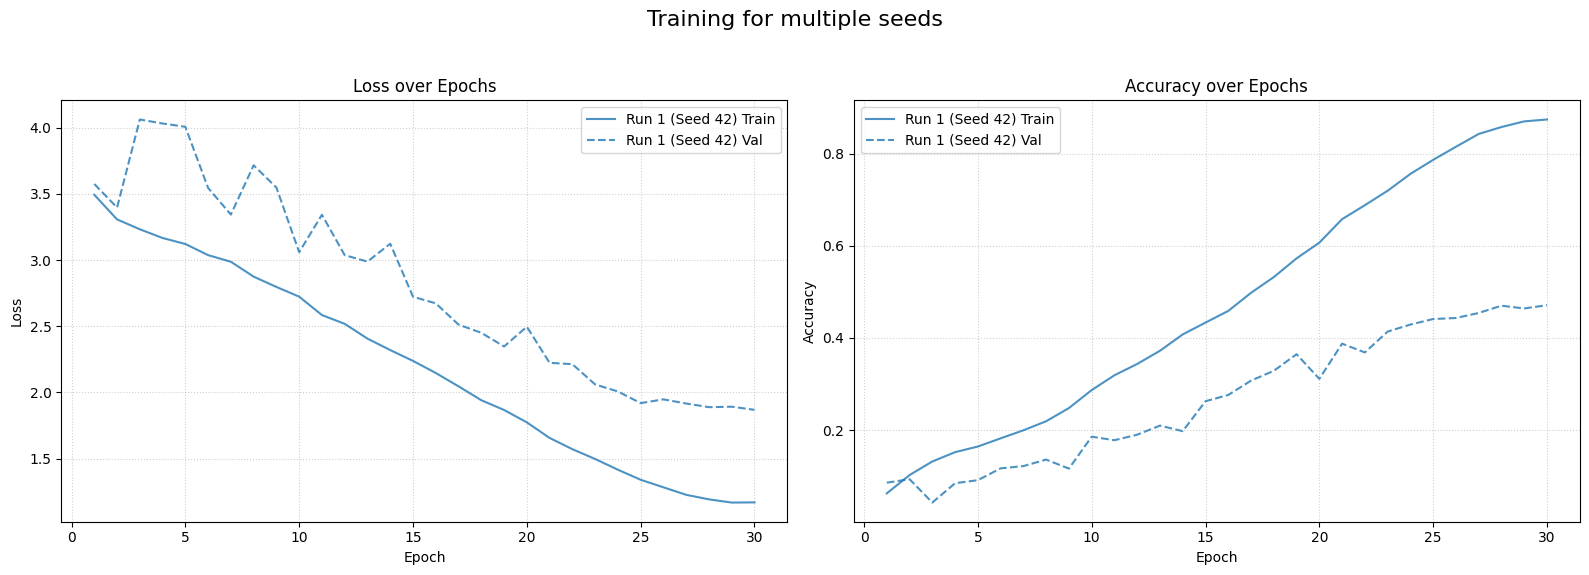

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes, use_skipConnections=False)
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["No_Skip"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Smaller weight decay


========================= RUNNING FOR SEED: 123 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 123 on the test set
Final Test Results for Seed 123: Loss=1.4335, Accuracy=0.5980

SUMMARY
Seeds used: [123]
Final Test Accuracies: ['0.5980']
Mean Test Accuracy: 0.5980
Std Dev of Test Accuracy: 0.0000


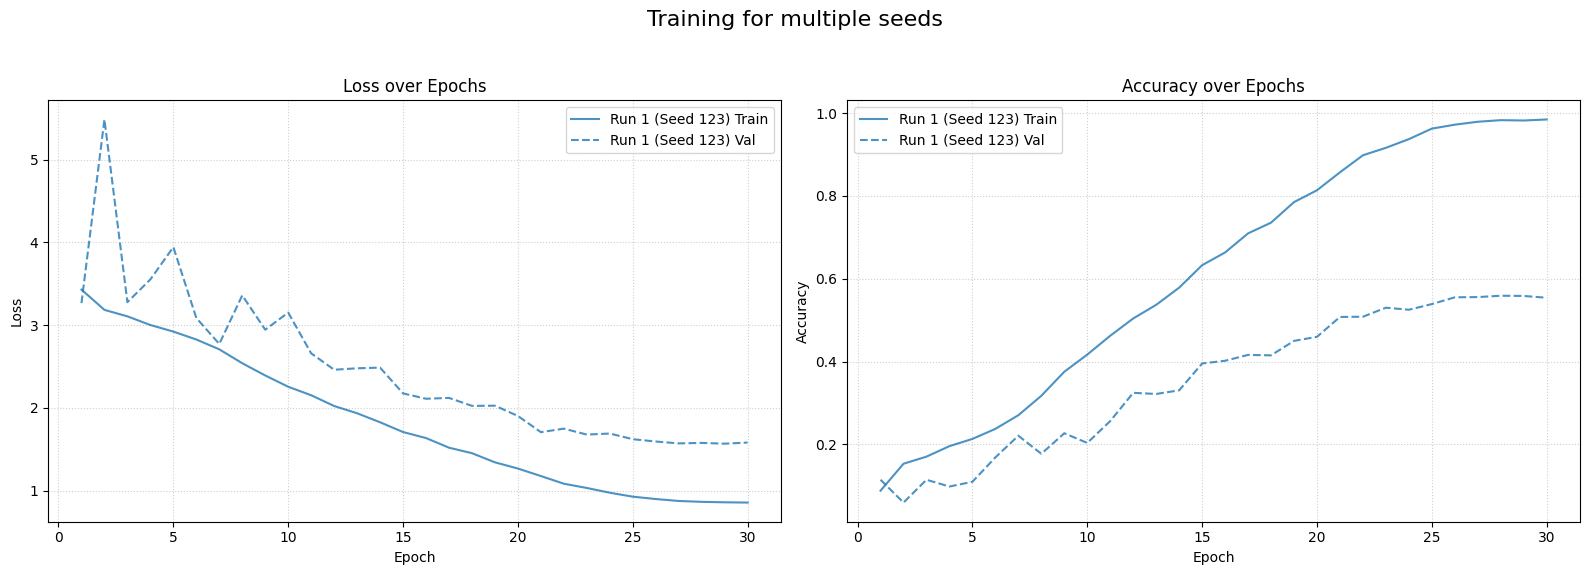

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes)
cfg_smaller_wd = cfg.copy()
cfg_smaller_wd["wd"] = 1e-4
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg_smaller_wd,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[123],
    print_training=False
)
results["Smaller_Weight_Decay"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Higher learning rate

Makes the optimization unstable and can cause divergence or poor convergence to suboptimal minima.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.6596, Accuracy=0.5406

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.5406']
Mean Test Accuracy: 0.5406
Std Dev of Test Accuracy: 0.0000


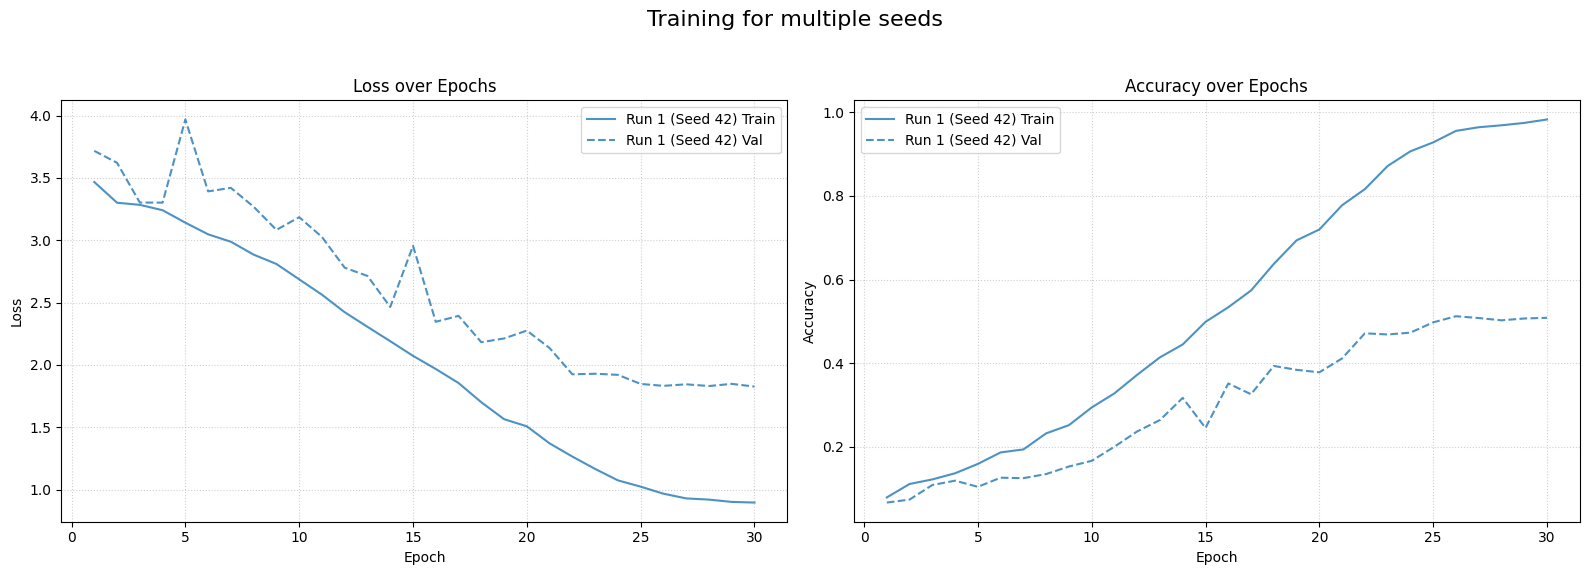

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes)
cfg_high_lr = cfg.copy()
cfg_high_lr["lr"] = cfg["lr"] * 5
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg_high_lr,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["Higher_LR"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Larger batch size

Resulted in worsening the performances of the network.


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=1.5140, Accuracy=0.5780

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.5780']
Mean Test Accuracy: 0.5780
Std Dev of Test Accuracy: 0.0000


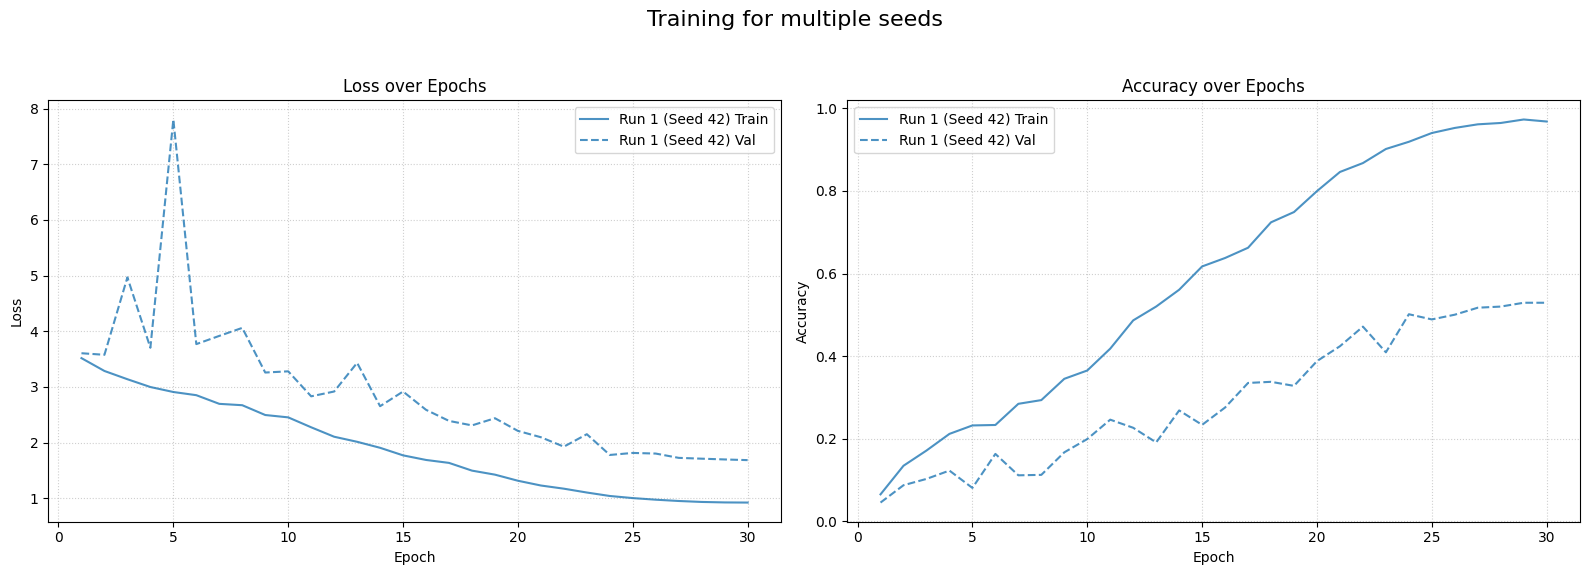

In [ ]:
model_factory = lambda: PetCustomModel(num_classes=num_classes)
cfg_big_batch = cfg.copy()
cfg_big_batch["batch_size"] = 256
histories, accuracies = train_MultipleSeeds(
    model_fn=model_factory,
    cfg=cfg_big_batch,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    seeds=[42],
    print_training=False
)
results["Bigger_Batch"] = {
    "histories": histories,
    "accuracies": accuracies
}

### Final comparison table

In [ ]:
import pandas as pd
import numpy as np

summary = []
for name, result in results.items():
    accs = result["accuracies"]
    mean_acc = sum(accs) / len(accs)

    final_train_accs = [h["train_acc"][-1] for h in result["histories"]]
    final_val_accs = [h["val_acc"][-1] for h in result["histories"]]
    final_train_losses = [h["train_loss"][-1] for h in result["histories"]]
    final_val_losses = [h["val_loss"][-1] for h in result["histories"]]

    mean_final_train_acc = np.mean(final_train_accs)
    mean_final_val_acc = np.mean(final_val_accs)
    mean_final_train_loss = np.mean(final_train_losses)
    mean_final_val_loss = np.mean(final_val_losses)


    summary.append({
        "Model": name,
        "Mean Test Accuracy": mean_acc,
        "Mean Final Train Accuracy": mean_final_train_acc,
        "Mean Final Val Accuracy": mean_final_val_acc,
        "Mean Final Train Loss": mean_final_train_loss,
        "Mean Final Val Loss": mean_final_val_loss
        })

df_summary = pd.DataFrame(summary).sort_values("Mean Test Accuracy", ascending=False)
display(df_summary)

,Model,Mean Test Accuracy,Mean Final Train Accuracy,Mean Final Val Accuracy,Mean Final Train Loss,Mean Final Val Loss
0,Best_Model,0.603467,0.986736,0.563795,0.852674,1.595815
5,Smaller_Channels,0.600217,0.965658,0.541439,0.928108,1.639408
10,Smaller_Weight_Decay,0.598050,0.984464,0.553980,0.854451,1.580134
2,Small_Stem,0.596425,0.981739,0.554526,0.869289,1.621482
4,Small_Conv,0.583424,0.981739,0.540894,0.911023,1.626062
9,Bigger_Batch,0.578007,0.968111,0.529444,0.921102,1.683559
6,Smaller_FC,0.557963,0.911693,0.508724,1.055705,1.746344
8,Higher_LR,0.540628,0.982829,0.508724,0.895738,1.826166
7,No_Skip,0.513001,0.873808,0.471101,1.170236,1.868898
3,No_Model,0.495125,0.707005,0.475463,1.663078,1.825682


### Final comparison graph

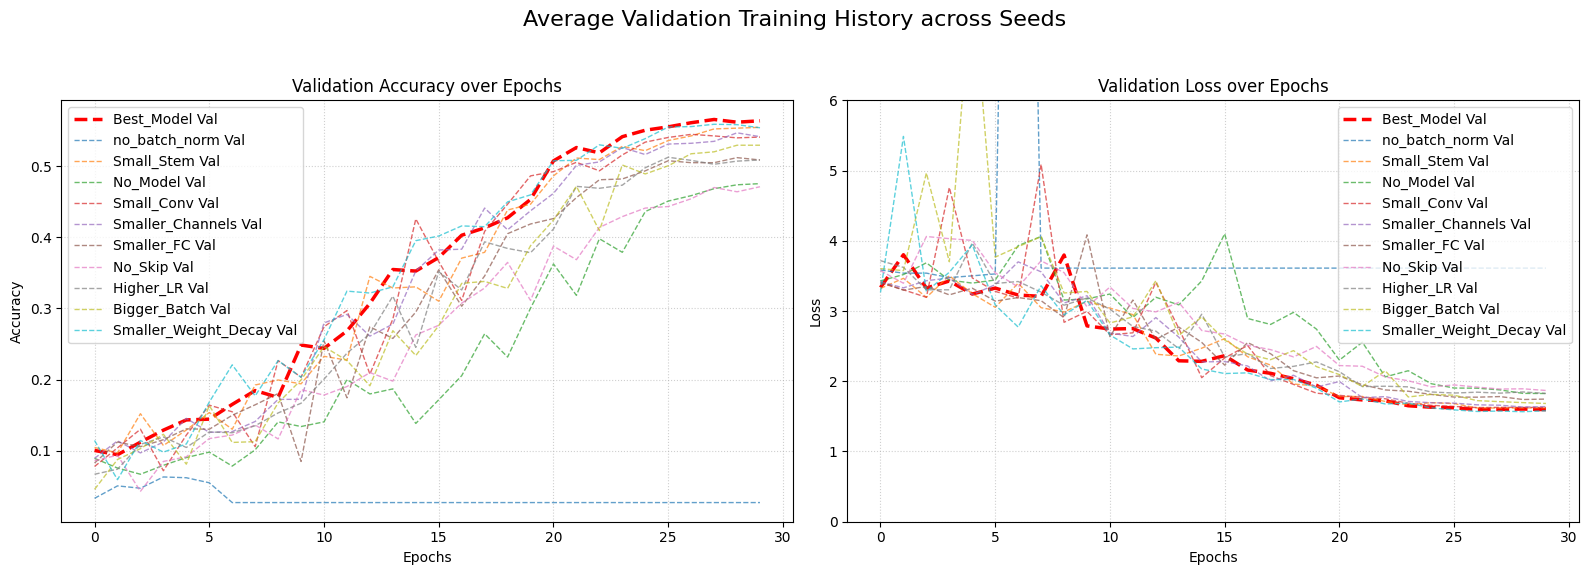

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,6))
fig.suptitle("Average Validation Training History across Seeds",fontsize=16)

for name, res in results.items():
    val_accs = [h["val_acc"] for h in res["histories"]]
    val_losses = [h["val_loss"] for h in res["histories"]]

    min_len = min(len(a) for a in val_accs)

    avg_val_acc_curve = np.mean([np.array(a[:min_len]) for a in val_accs],axis=0)
    avg_val_loss_curve = np.mean([np.array(a[:min_len]) for a in val_losses],axis=0)

    if name == "Best_Model":
        linewidth =2.5
        alpha =1.0
        color ='red'
    else:
        linewidth =1.0
        alpha =0.7
        color =None

    # Plot the accuracy
    ax1.plot(avg_val_acc_curve,linestyle='--',label=f"{name} Val",linewidth=linewidth,alpha=alpha,color=color)

    # Plot the loss
    ax2.plot(avg_val_loss_curve,linestyle='--',label=f"{name} Val",linewidth=linewidth,alpha=alpha,color=color)


ax1.set_title("Validation Accuracy over Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.6)

ax2.set_title("Validation Loss over Epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.set_ylim(0, 6)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Part 2 A
In this section, we'll fine-tune a pre-trained ResNet-18 model using **the same hyperparameters from Part 1**. We'll use two different strategies.

- **Initial step. Frozen CNN Training**:
   - Trains with all CNN layers frozen, only the classifier trainable
   - **Saves the best model weights**

- **Strategy 1. Partial Fine-Tuning**:
   - **Starts from the saved frozen CNN weights**
   - Unfreezes `layer4` while keeping earlier layers frozen
- **Strategy 2. Full fine tuning**:
   - **Starts from the saved frozen CNN weights**
   - Unfreezes all layers for complete fine-tuning

In [ ]:
def get_model(
        num_classes: int,
        weights:Optional[ResNet18_Weights] = None,
        freeze_strategy:str = "all"
    ) -> nn.Module:
    """Creates a ResNet-18 model for transfer learning with different freezing strategies.

    Args:
        num_classes: the number of classes.
        weights: pretrained weights to load into the network.
                 If None, the network is randomly initialized.
        freeze_strategy: "all"->(freeze all), "partial"->(freeze early layers (not 4)),"none"->(freeze nothing)
    """

    model = resnet18(weights=weights)
    # classifier overriding
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if freeze_strategy == "all":
      # freeze all convolutional layers
      set_requires_grad(model.conv1, False)
      set_requires_grad(model.bn1, False)
      set_requires_grad(model.layer1, False)
      set_requires_grad(model.layer2, False)
      set_requires_grad(model.layer3, False)
      set_requires_grad(model.layer4, False)

    elif freeze_strategy == "partial":
      # Freeze early layers, unfreeze later layers (layer4) + classifier
      set_requires_grad(model.conv1,False)
      set_requires_grad(model.bn1,False)
      set_requires_grad(model.layer1,False)
      set_requires_grad(model.layer2,False)
      set_requires_grad(model.layer3,False)
    else:
      pass
    return model

In [ ]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [ ]:
def print_trainable_parameters(model: nn.Module,model_name:str="Model") ->None:
    """Prints the number of trainable vs total parameters in the model."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params-trainable_params

    print(f"\n{model_name} Parameter Summary:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
    print(f"Frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")
    print("-" * 50)

### Initial step: Frozen CNN + Classifier tuning
 First, we freeze all convolutional layers and only train the final classifier. We expect to obtain fairly good results since our dataset is not particularly hard.

In [ ]:
weights = ResNet18_Weights.IMAGENET1K_V1
frozen_model_factory = lambda: get_model(
    num_classes=num_classes,
    weights=weights,
    freeze_strategy="all" # we freeze all
).to(device)

sample_model = frozen_model_factory()
print_trainable_parameters(sample_model, "Frozen ResNet-18")


Frozen ResNet-18 Parameter Summary:
Total parameters: 11,195,493
Trainable parameters: 18,981 (0.2%)
Frozen parameters: 11,176,512 (99.8%)
--------------------------------------------------



========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

[Epoch 1/30] Train Loss: 3.5131, Train Acc: 0.0891 | Val Loss: 3.0955, Val Acc: 0.2105
[Epoch 5/30] Train Loss: 1.1884, Train Acc: 0.8793 | Val Loss: 0.6690, Val Acc: 0.8430
[Epoch 10/30] Train Loss: 0.9986, Train Acc: 0.9324 | Val Loss: 0.6050, Val Acc: 0.8517
[Epoch 15/30] Train Loss: 0.9393, Train Acc: 0.9610 | Val Loss: 0.6078, Val Acc: 0.8381
[Epoch 20/30] Train Loss: 0.8991, Train Acc: 0.9700 | Val Loss: 0.6003, Val Acc: 0.8528
[Epoch 25/30] Train Loss: 0.8755, Train Acc: 0.9793 | Val Loss: 0.5916, Val Acc: 0.8555
[Epoch 30/30] Train Loss: 0.8604, Train Acc: 0.9847 | Val Loss: 0.5906, Val Acc: 0.8550

Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=0.5305, Accuracy=0.8727

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.8727']
Mean Test Accuracy: 0.8727
Std Dev of Test Accuracy: 0.0000


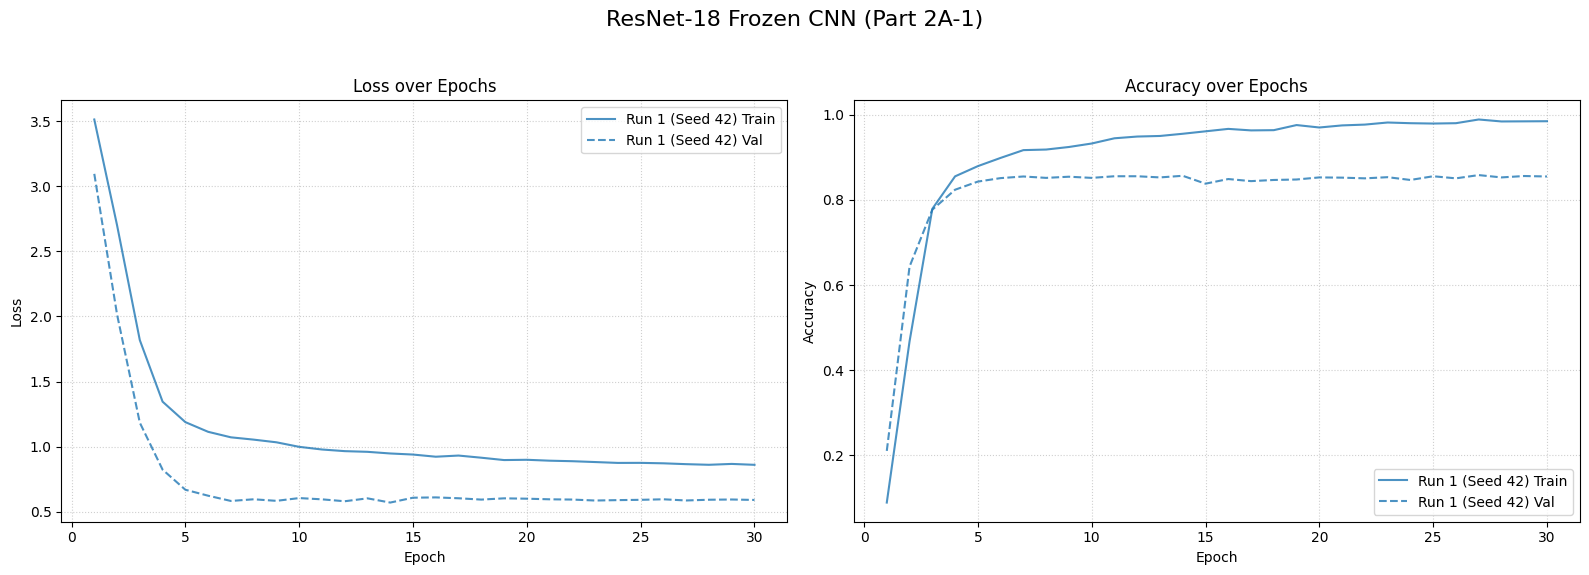

In [ ]:
# Train the frozen model with part 1 hyperpameters
cfg_part1= {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 30,
    "lr": 1e-3,
    "wd": 3e-4,
    "step_size": 5
}

frozen_histories, frozen_accuracies = train_MultipleSeeds(
    model_fn=frozen_model_factory,
    cfg=cfg_part1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    print_training=True,
    seeds=[42],
    title="ResNet-18 Frozen CNN (Part 2A-1)"
)
results={}

In [ ]:
best_frozen_model = frozen_model_factory()
best_checkpoint_path = Path("ckpts") / "42.pt"
best_frozen_model.load_state_dict(torch.load(best_checkpoint_path))
frozen_weights_path = "/tmp/frozen_cnn_weights.pth"
torch.save(best_frozen_model.state_dict(), frozen_weights_path)

### Strategy 1 - Part 2A
Now we unfreeze the last convolutional layers (layer4) while keeping earlier layers frozen. This allows the model to adapt high-level features while preserving low-level features learned on ImageNet. What we expect anyway is not an increase in the performance since we stuck using part 1 hyperparameters.

In [ ]:
def partial_model():
    """
    Creates the partial fine tuning model starting from the frozen weights
    """
    model = get_model(
        num_classes=num_classes,
        weights=None,
        freeze_strategy="partial"  # Apply partial freezing directly
    ).to(device)

    # Load the frozen CNN weights as starting point
    model.load_state_dict(torch.load(frozen_weights_path))

    return model
sample_model = partial_model()
print_trainable_parameters(sample_model, "Partial ResNet-18 (from frozen weights)")


Partial ResNet-18 (from frozen weights) Parameter Summary:
Total parameters: 11,195,493
Trainable parameters: 8,412,709 (75.1%)
Frozen parameters: 2,782,784 (24.9%)
--------------------------------------------------



========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1/10] Train Loss: 1.0166, Train Acc: 0.9207 | Val Loss: 1.0550, Val Acc: 0.7154
[Epoch 5/10] Train Loss: 0.8805, Train Acc: 0.9711 | Val Loss: 0.7727, Val Acc: 0.8059
[Epoch 10/10] Train Loss: 0.7210, Train Acc: 0.9997 | Val Loss: 0.6983, Val Acc: 0.8577

Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=0.5914, Accuracy=0.8770

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.8770']
Mean Test Accuracy: 0.8770
Std Dev of Test Accuracy: 0.0000


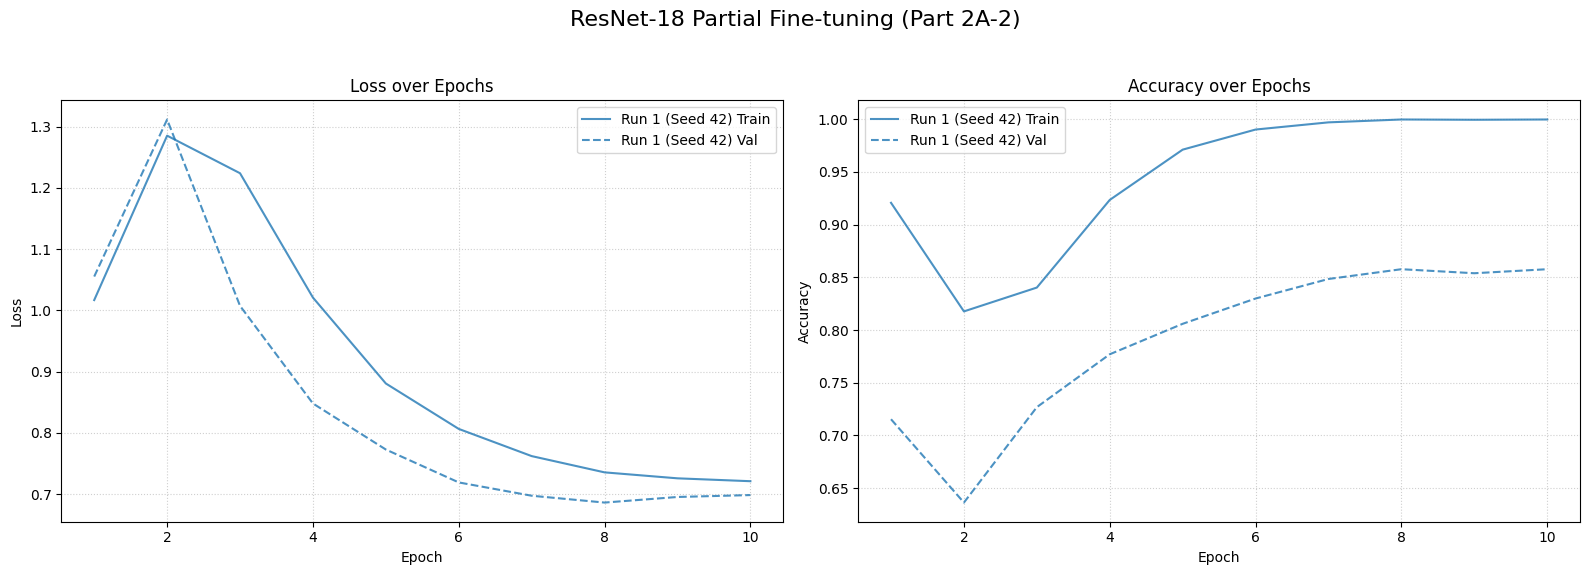

In [ ]:
# Train the partial model
cfg_part1["num_epochs"]=10

partial_histories, partial_accuracies = train_MultipleSeeds(
    model_fn=partial_model,
    cfg=cfg_part1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    print_training=True,
    seeds=[42],
    title="ResNet-18 Partial Fine-tuning (Part 2A-2)"
)

# Store results
results["ResNet18_Partial_Finetune"] = {
    "histories": partial_histories,
    "accuracies": partial_accuracies
}

### Strategy 2 - Part 2A

Unfreeze the entire model and fine tune it, using the same hypeparameters of the custom network.

In [ ]:
def full_model():
    """Creates full fine-tuning model starting from frozen weights."""
    model = get_model(
        num_classes=num_classes,
        weights=None,  # Don't load ImageNet weights
        freeze_strategy="none"
    ).to(device)

    # Load the frozen CNN weights as starting point
    model.load_state_dict(torch.load(frozen_weights_path))

    # Unfreeze all layers for full fine-tuning
    for param in model.parameters():
        param.requires_grad = True

    return model


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

[Epoch 1/10] Train Loss: 1.0742, Train Acc: 0.8981 | Val Loss: 1.7065, Val Acc: 0.5164
[Epoch 5/10] Train Loss: 1.2248, Train Acc: 0.8335 | Val Loss: 1.2587, Val Acc: 0.6592
[Epoch 10/10] Train Loss: 0.7484, Train Acc: 0.9984 | Val Loss: 0.8404, Val Acc: 0.8059

Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=0.7507, Accuracy=0.8304

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.8304']
Mean Test Accuracy: 0.8304
Std Dev of Test Accuracy: 0.0000


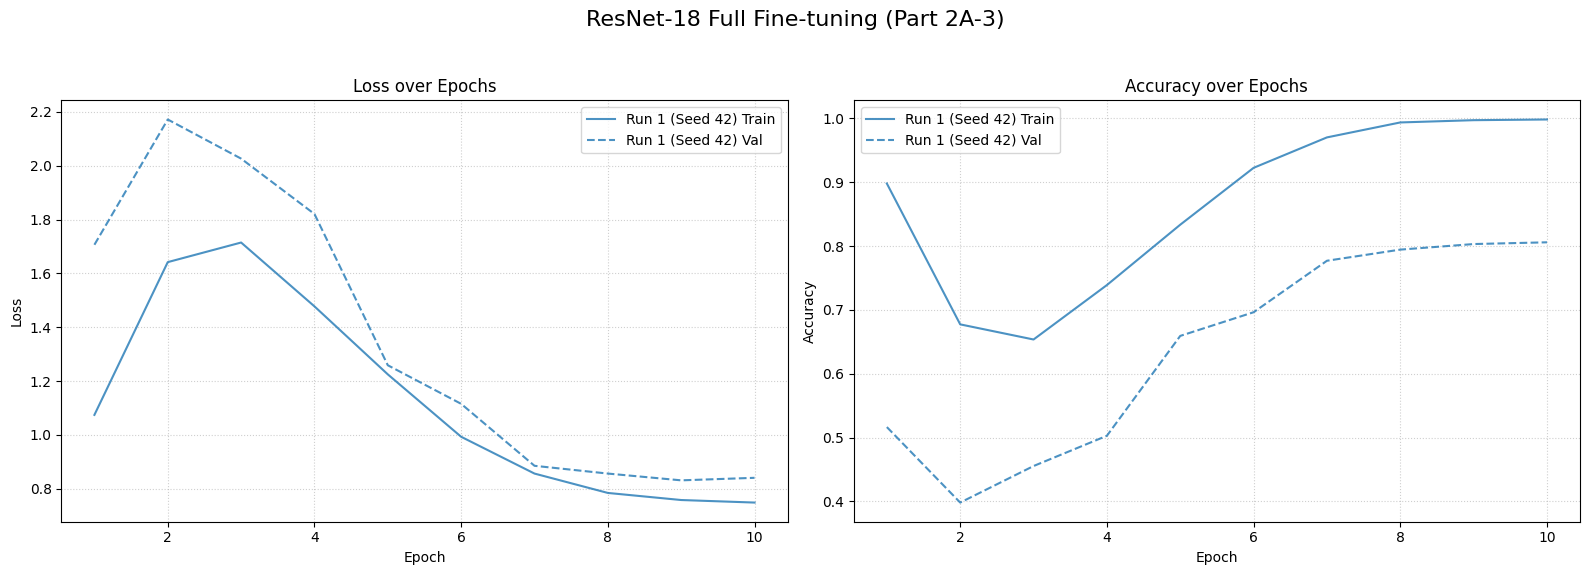

In [ ]:
# Train the full model
full_histories, full_accuracies = train_MultipleSeeds(
    model_fn=full_model,
    cfg=cfg_part1,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    print_training=True,
    seeds=[42],
    title="ResNet-18 Full Fine-tuning (Part 2A-3)"
)

# Store results
results["ResNet18_Full_Finetune_Part1"] = {
    "histories": full_histories,
    "accuracies": full_accuracies
}

### Results Analysis

**Key Observations from Part 2A:**

As we expected, the results obtained using the same hyperparameters of Part 1 are not optimal since the LR is way too high and it causes:

1. **Catastrophic Forgetting**: The high learning rate (1e-3) destroys the carefully learned ImageNet features during the transfer learning with the frozen CNN.
2. **Training Instability**: Especially visible in partial and full fine-tuning where pre-trained weights are being updated
3. **Poor Convergence**: The model struggles to adapt to the new task while preserving useful pre-trained knowledge

**Performance Pattern:**
- **Frozen CNN performs almost the best**: Only the classifier is trained, so high LR doesn't damage pre-trained features
- **Fine-tuning experiments suffer**: High LR disrupts the delicate pre-trained feature representations, the fine tuning of the entire architecture suffered a lot
- **Clear need for optimization**: This motivates Part 2B with carefully tuned hyperparameters for fine-tuning

## Part 2B: Fine-Tune with optimized Hyperparameters

Based on Part 2A results, we'll now optimize the hyperparameters for transfer learning and fine-tuning.

Key adjustments for the fine tuning:
1. **Lower Learning Rate**
2. **Higher Weight Decay**: Prevents overfitting to the smaller pet dataset
3. **Longer Training**: Allow the model to slowly adapt



========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 1/20] Train Loss: 3.7211, Train Acc: 0.0431 | Val Loss: 3.5396, Val Acc: 0.0714
[Epoch 5/20] Train Loss: 1.3756, Train Acc: 0.8553 | Val Loss: 0.8629, Val Acc: 0.8353
[Epoch 10/20] Train Loss: 1.0548, Train Acc: 0.9250 | Val Loss: 0.6185, Val Acc: 0.8561
[Epoch 15/20] Train Loss: 0.9978, Train Acc: 0.9441 | Val Loss: 0.5748, Val Acc: 0.8680
[Epoch 20/20] Train Loss: 0.9836, Train Acc: 0.9542 | Val Loss: 0.5809, Val Acc: 0.8680

Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=0.5264, Accuracy=0.8738

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.8738']
Mean Test Accuracy: 0.8738
Std Dev of Test Accuracy: 0.0000


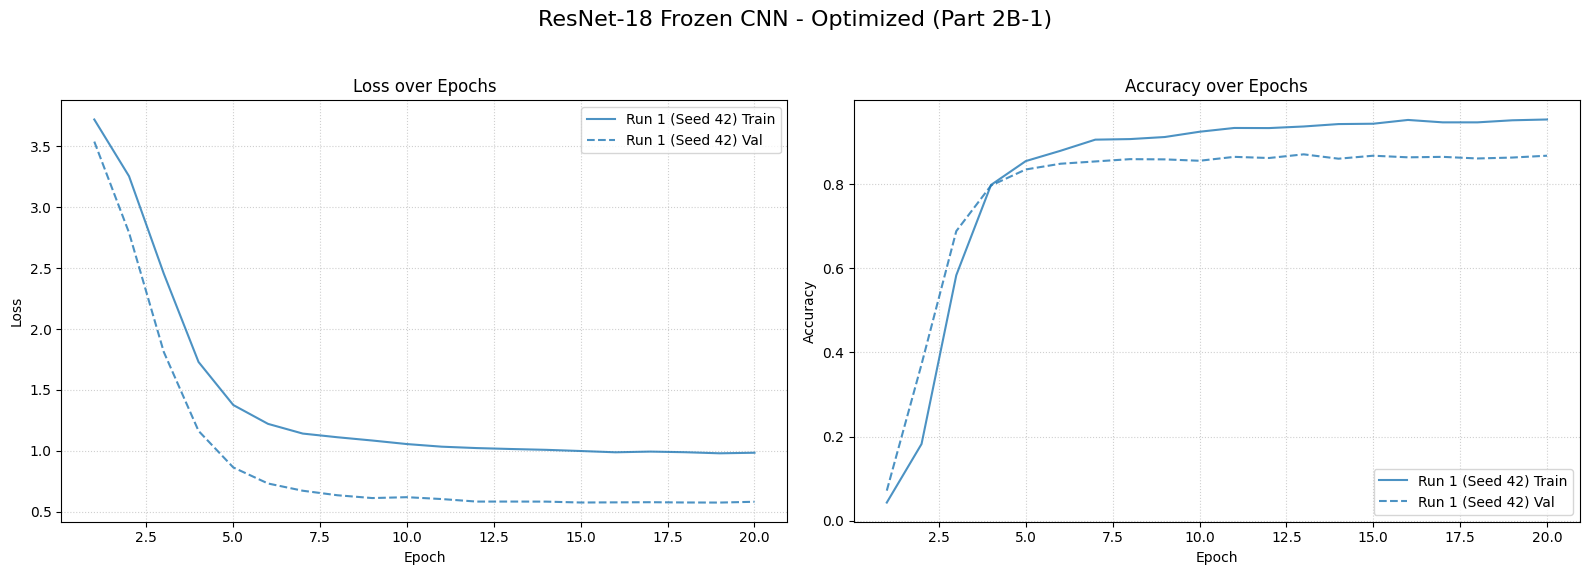

In [ ]:
# Optimized hyperparameters specifically for classifier-only training (frozen CNN)
cfg_classifier_opt = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 20,   # Moderate epochs - classifier converges faster than full network
    "lr": 3e-4,         # Slightly lower than Part 1 for more stable training
    "wd": 1e-3,         # Higher weight decay for better regularization
    "step_size": 3      # Step every 5 epochs
}

frozen_model_factory_opt = lambda: get_model(
    num_classes=num_classes,
    weights=ResNet18_Weights.IMAGENET1K_V1,
    freeze_strategy="all"
).to(device)

# Train with optimized classifier hyperparameters
frozen_opt_histories, frozen_opt_accuracies = train_MultipleSeeds(
    model_fn=frozen_model_factory_opt,
    cfg=cfg_classifier_opt,  # Use classifier-specific optimized config
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    print_training=True,
    seeds=[42],
    title="ResNet-18 Frozen CNN - Optimized (Part 2B-1)"
)

In [ ]:
best_frozen_model = frozen_model_factory_opt()
best_checkpoint_path = Path("ckpts") / "42.pt"
best_frozen_model.load_state_dict(torch.load(best_checkpoint_path))
frozen_weights_path = "/tmp/frozen_cnn_weights.pth"
torch.save(best_frozen_model.state_dict(), frozen_weights_path)

## Strategy 1 - Part 2B

In [ ]:
# Optimized hyperparameters for fine-tuning
cfg_optimized = {
    "resize_size": 256,
    "crop_size": 224,
    "batch_size": 32,
    "num_epochs": 15,  # Fewer epochs for finetuning
    "lr": 7e-5,        # lower LR for fine-tuning
    "wd": 2e-4,        # Higher weight decay for regularization
    "step_size": 5
}


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1/15] Train Loss: 0.9959, Train Acc: 0.9482 | Val Loss: 0.5730, Val Acc: 0.8675
[Epoch 5/15] Train Loss: 0.8113, Train Acc: 0.9910 | Val Loss: 0.6128, Val Acc: 0.8582
[Epoch 10/15] Train Loss: 0.7308, Train Acc: 0.9997 | Val Loss: 0.6439, Val Acc: 0.8691
[Epoch 15/15] Train Loss: 0.7140, Train Acc: 1.0000 | Val Loss: 0.6429, Val Acc: 0.8719

Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=0.5510, Accuracy=0.8944

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.8944']
Mean Test Accuracy: 0.8944
Std Dev of Test Accuracy: 0.0000


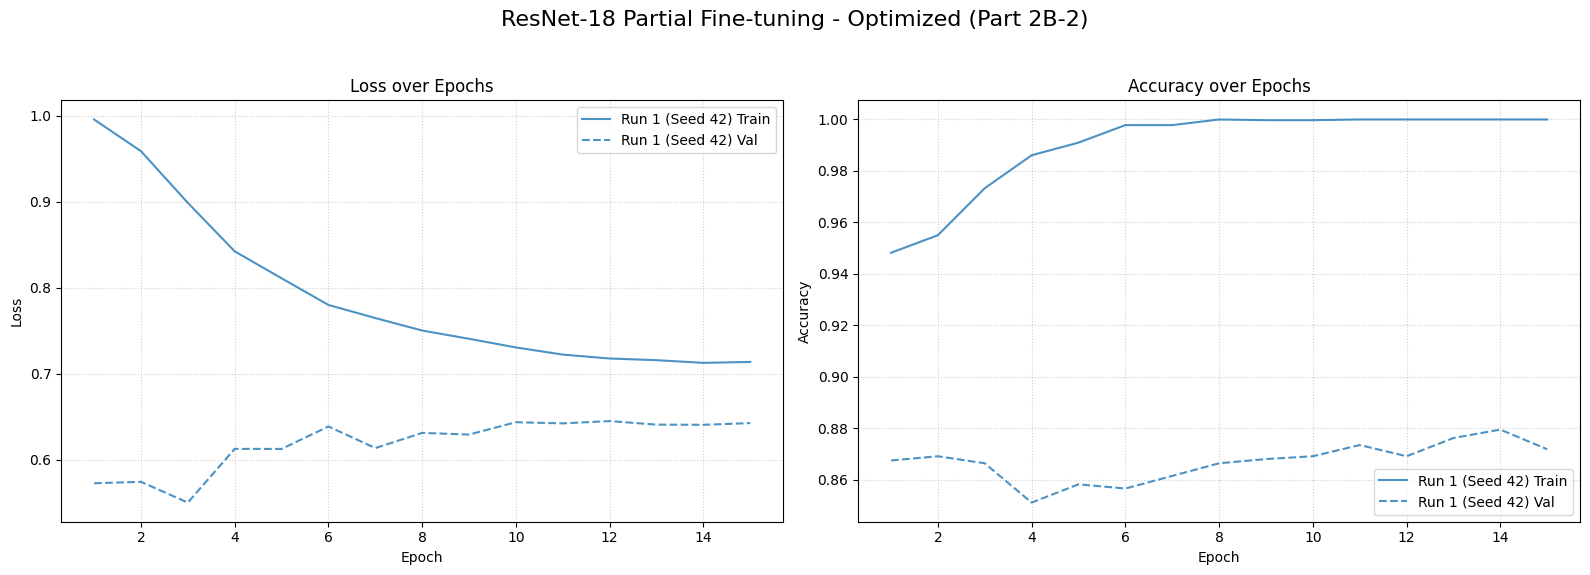

In [ ]:
# Train with optimized hyperparameters
partial_opt_histories, partial_opt_accuracies = train_MultipleSeeds(
    model_fn=partial_model,
    cfg=cfg_optimized,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    print_training=True,
    seeds=[42],
    title="ResNet-18 Partial Fine-tuning - Optimized (Part 2B-2)"
)

# Store results
results["ResNet18_Partial_Finetune_Optimized"] = {
    "histories": partial_opt_histories,
    "accuracies": partial_opt_accuracies
}

## Strategy 2 - Part 2B


========================= RUNNING FOR SEED: 42 =========================



Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1/15] Train Loss: 0.9920, Train Acc: 0.9469 | Val Loss: 0.5578, Val Acc: 0.8713
[Epoch 5/15] Train Loss: 0.8180, Train Acc: 0.9888 | Val Loss: 0.6567, Val Acc: 0.8310
[Epoch 10/15] Train Loss: 0.7254, Train Acc: 0.9997 | Val Loss: 0.6394, Val Acc: 0.8702
[Epoch 15/15] Train Loss: 0.7072, Train Acc: 1.0000 | Val Loss: 0.6312, Val Acc: 0.8730

Evaluating best model for seed 42 on the test set
Final Test Results for Seed 42: Loss=0.5476, Accuracy=0.9030

SUMMARY
Seeds used: [42]
Final Test Accuracies: ['0.9030']
Mean Test Accuracy: 0.9030
Std Dev of Test Accuracy: 0.0000


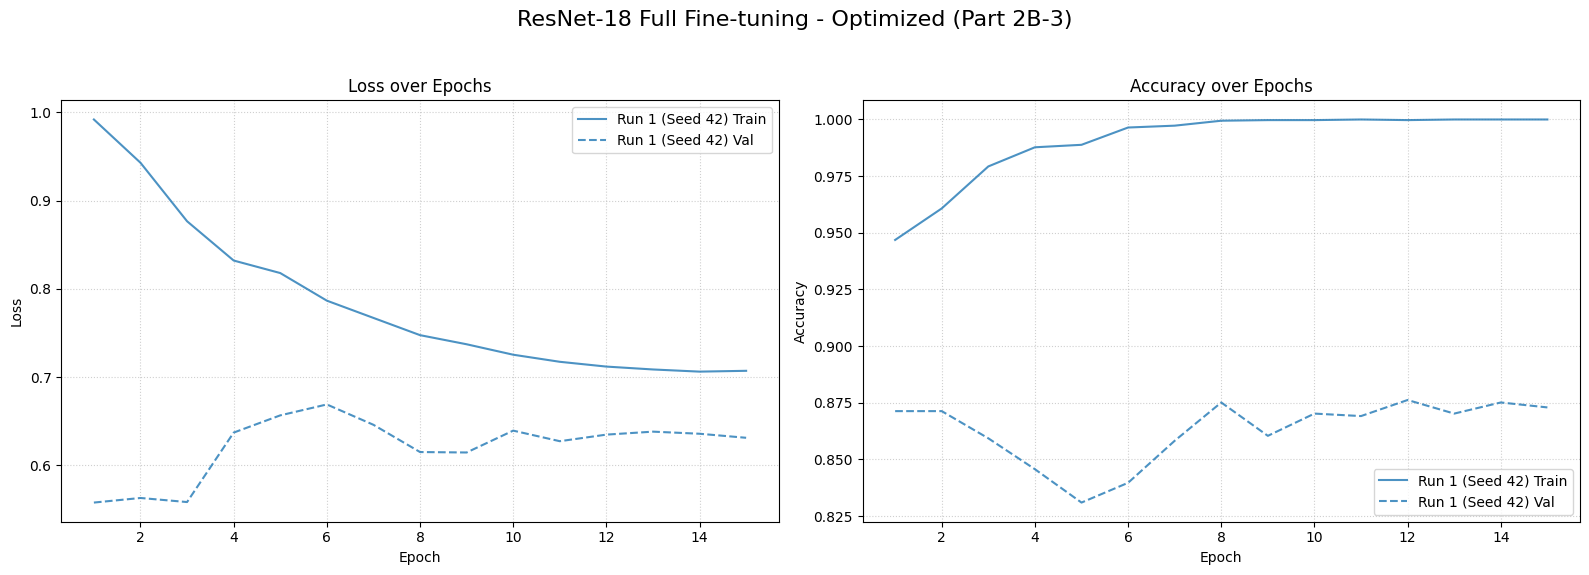

In [ ]:
# Train with optimized hyperparameters
full_opt_histories, full_opt_accuracies = train_MultipleSeeds(
    model_fn=full_model,
    cfg=cfg_optimized,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    device=device,
    print_training=True,
    seeds=[42],
    title="ResNet-18 Full Fine-tuning - Optimized (Part 2B-3)"
)

# Store results
results["ResNet18_Full_Finetune_Optimized"] = {
    "histories": full_opt_histories,
    "accuracies": full_opt_accuracies
}

Even if validation loss did not improve, the validation accuracy slightly improved, and the results showed an improvement in the test set, reaching the threshold accuracy of 90%. Looking at the training data the model showed quite overfitting but we reached the implementation goal.

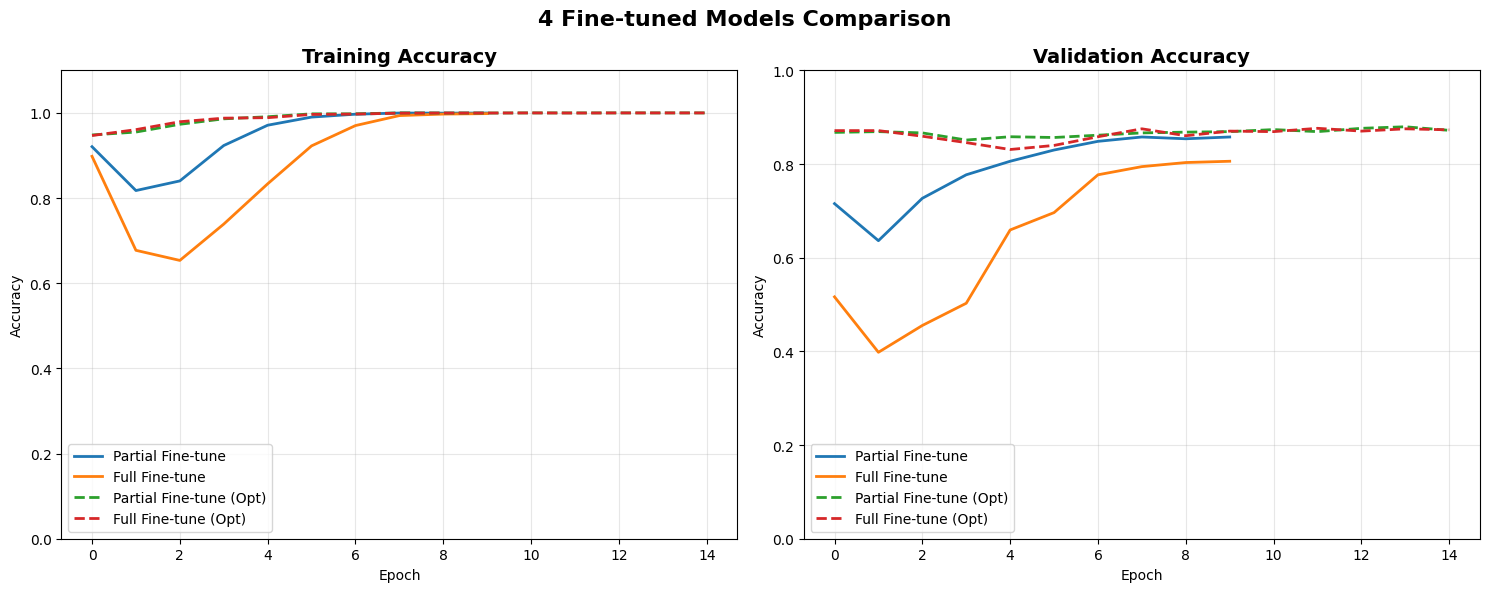


FINAL TEST ACCURACIES
Partial Fine-tune (part 2A):     0.8770
Full Fine-tune (part 2A):        0.8304
Partial Fine-tune Opt (part 2B): 0.8944
Full Fine-tune Opt (part 2B):    0.9030

Best Model: Full Fine-tune Opt (0.9030)


In [ ]:
hist1 = results["ResNet18_Partial_Finetune"]["histories"][0]
hist2 = results["ResNet18_Full_Finetune_Part1"]["histories"][0]
hist3 = results["ResNet18_Partial_Finetune_Optimized"]["histories"][0]
hist4 = results["ResNet18_Full_Finetune_Optimized"]["histories"][0]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

# Plot training accuracy
ax1.plot(hist1['train_acc'],label='Partial Fine-tune',linewidth=2)
ax1.plot(hist2['train_acc'],label='Full Fine-tune',linewidth=2)
ax1.plot(hist3['train_acc'],label='Partial Fine-tune (Opt)',linewidth=2, linestyle='--')
ax1.plot(hist4['train_acc'],label='Full Fine-tune (Opt)',linewidth=2, linestyle='--')

ax1.set_title('Training Accuracy',fontsize=14,fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy' )
ax1.legend( )
ax1.grid(True,alpha=0.3)
ax1.set_ylim(0,1.1)

# Plot the validation accuracy
ax2.plot(hist1['val_acc'],label='Partial Fine-tune', linewidth=2)
ax2.plot(hist2['val_acc'],label='Full Fine-tune', linewidth=2)
ax2.plot(hist3['val_acc'],label='Partial Fine-tune (Opt)', linewidth=2, linestyle='--')
ax2.plot(hist4['val_acc'],label='Full Fine-tune (Opt)', linewidth=2, linestyle='--')

ax2.set_title('Validation Accuracy',fontsize=14,fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True,alpha=0.3)
ax2.set_ylim(0,1)

plt.suptitle('4 Fine-tuned Models Comparison',fontsize=16,fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("FINAL TEST ACCURACIES")
print("="*50)
print(f"Partial Fine-tune (part 2A):     {results['ResNet18_Partial_Finetune']['accuracies'][0]:.4f}")
print(f"Full Fine-tune (part 2A):        {results['ResNet18_Full_Finetune_Part1']['accuracies'][0]:.4f}")
print(f"Partial Fine-tune Opt (part 2B): {results['ResNet18_Partial_Finetune_Optimized']['accuracies'][0]:.4f}")
print(f"Full Fine-tune Opt (part 2B):    {results['ResNet18_Full_Finetune_Optimized']['accuracies'][0]:.4f}")

# we find the best model
accuracies = [
    results['ResNet18_Partial_Finetune']['accuracies'][0],
    results['ResNet18_Full_Finetune_Part1']['accuracies'][0],
    results['ResNet18_Partial_Finetune_Optimized']['accuracies'][0],
    results['ResNet18_Full_Finetune_Optimized']['accuracies'][0]
]
models = ['Partial Fine-tune', 'Full Fine-tune', 'Partial Fine-tune Opt', 'Full Fine-tune Opt']
best_idx = accuracies.index(max(accuracies))

print(f"\nBest Model: {models[best_idx]} ({accuracies[best_idx]:.4f})")

## Results Analysis

- With fine-tuning we are able to reach **90%** accuracy.
- **Hyperparameter optimization** improved results for both partial and full fine-tuning.
- Validation/Training accuracy curves do not show catastrophic forgetting as before but in general show quite overfitting along the training, and the validation loss do not improve drastically during the second fine tuning stage. This is due to the first part with the frozen backbone of the network already performing good since the dataset is not so different from part of the data on which the original network was pretrained on.
- Partial fine-tuning is still competitive but slightly below full fine-tuning (0.8944 vs 0.9030).
- Optimized learning rate and scheduler preserved pre-trained features effectively.
---

## Conclusions
1. Proper hyperparameter tuning is critical for successful fine-tuning.
2. Full fine-tuning with careful LR and scheduling achieves the **highest generalization**.
3. Test accuracy (0.903) demonstrates strong model performance on the target dataset.
4. Further improvements possible via more data augmentations or layer-wise LR decay.